In [125]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tgs-salt-identification-challenge/flamingo.zip
/kaggle/input/tgs-salt-identification-challenge/test.zip
/kaggle/input/tgs-salt-identification-challenge/train.csv
/kaggle/input/tgs-salt-identification-challenge/competition_data.zip
/kaggle/input/tgs-salt-identification-challenge/train.zip
/kaggle/input/tgs-salt-identification-challenge/depths.csv
/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv


In [126]:
import sys
import random

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

#%matplotlib inline
%matplotlib notebook
from ipywidgets import *
from sklearn.model_selection import train_test_split
from PIL import Image
from zipfile import ZipFile
from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [127]:
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout,concatenate
from tensorflow.keras.layers import Conv2D,MaxPool2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

In [128]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("/kaggle/input/tgs-salt-identification-challenge/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("/kaggle/input/tgs-salt-identification-challenge/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df), len(test_df)

(4000, 18000)

In [129]:
zip_path = "/kaggle/input/tgs-salt-identification-challenge/train.zip"
with ZipFile(zip_path) as myzip:
    files_in_zip = myzip.namelist()
len(files_in_zip) #have image and mask both

8002

Unzip train folder and convert image and mask into array with resize(128), original image size = 101

In [130]:
X = np.zeros((len(train_df), 128,128,1), dtype = np.float32)
y = np.zeros((len(train_df), 128,128,1), dtype = np.float32)

In [131]:
with ZipFile(zip_path) as myzip:
    #df_list = []
    count = 0 
    for idx in tqdm_notebook(train_df.index):
        img_name = 'images/{}.png'.format(idx)
        mask_name = 'masks/{}.png'.format(idx)
        if img_name in files_in_zip and mask_name in files_in_zip:
            img = np.asarray(Image.open(myzip.open(img_name)).convert("L"))/255
            img = resize(img, (128, 128, 1), mode = 'constant', preserve_range = True)
            mask = np.asarray(Image.open(myzip.open(mask_name)).convert("L"))/255
            mask = resize(img, (128, 128, 1), mode = 'constant', preserve_range = True)
            X[count] = img
            y[count] = mask
            count+=1
            #df_list.append([idx,img_name,mask_name,img, mask])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [132]:
#df = pd.DataFrame(df_list, columns=['id', 'image_name', 'mask_name', 'img_array', 'mask_array'])

In [133]:
#df.head()

In [134]:
X.shape, y.shape

((4000, 128, 128, 1), (4000, 128, 128, 1))

Split into train and valid 

In [135]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.1, random_state=42)

In [136]:
X_train.shape, X_valid.shape

((3600, 128, 128, 1), (400, 128, 128, 1))

Visualize the images and corresponding masks

In [137]:
def plot_interactive(idx):
    ix = idx
    has_mask = y_train[ix].max() > 0 # salt indicator
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
    ax1.imshow(X_train[ix].squeeze(), cmap = 'seismic', interpolation = 'bilinear')
    if has_mask: # if salt
        # draw a boundary(contour) in the original image separating salt and non-salt areas
        ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
    ax1.set_title('Seismic')
    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Salt')
    #plt.show()
interact(plot_interactive, idx = list(range(len(X_train))))
#plot_interactive(0)

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.plot_interactive(idx)>

U-Net model 

In [138]:
def contract_conv(inps, num_filter):
    c = Conv2D(num_filter, 3, activation='relu',padding="same",kernel_initializer='he_normal')(inps)
    c = Conv2D(num_filter, 3, activation='relu',padding="same",kernel_initializer='he_normal')(c)
    c = BatchNormalization()(c)
    return c

In [153]:
def UNet_Model(input_img):
    dropout = 0.35
    #contracting path
    u1 = contract_conv(input_img, 16)
    p1 = MaxPooling2D(pool_size=(2, 2))(u1)
    p1 = Dropout(dropout)(p1)
    
    u2 = contract_conv(p1, 32)
    p2 = MaxPooling2D(pool_size=(2, 2))(u2)
    p2 = Dropout(dropout)(p2)
    
    u3 = contract_conv(p2, 64)
    p3 = MaxPooling2D(pool_size=(2, 2))(u3)
    p3 = Dropout(dropout)(p3)
    
    u4 = contract_conv(p3, 128)
    p4 = MaxPooling2D(pool_size=(2, 2))(u4)
    p4 = Dropout(dropout)(p4)
    
    u5 = contract_conv(p4, 256)
    
    #expansive path
    
    u6 = Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(u5)
    u6 = concatenate([u6,u4])
    u6 = Dropout(dropout)(u6)
    u6 = contract_conv(u6, 128)
    
    u7 = Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(u6)
    u7 = concatenate([u7,u3])
    u7 = Dropout(dropout)(u7)
    u7 = contract_conv(u7, 128)
    
    u8 = Conv2DTranspose(32, 3, strides=(2, 2), padding='same')(u7)
    u8 = concatenate([u8,u2])
    u8 = Dropout(dropout)(u8)
    u8 = contract_conv(u8, 128)
    
    u9 = Conv2DTranspose(16, 3, strides=(2, 2), padding='same')(u8)
    u9 = concatenate([u9,u1])
    u9 = Dropout(dropout)(u9)
    u9 = contract_conv(u9, 16)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(u9)
    model = Model(inputs= [input_img], outputs= [outputs])
    return model

In [154]:
input_img = Input((128,128,1), name = 'img')
model = UNet_Model(input_img)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [155]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_184[0][0]                 
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 128, 128, 16) 64          conv2d_185[0][0]                 
____________________________________________________________________________________________

In [149]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [150]:
results = model.fit(X_train,y_train,batch_size= 32, epochs= 50, callbacks=callbacks,validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.6512
Epoch 00001: val_loss improved from inf to 0.66223, saving model to model-tgs-salt.h5
113/113 [==============================] - 9s 79ms/step - loss: 0.6512 - val_loss: 0.6622 - lr: 0.0010
Epoch 2/50
112/113 [============================>.] - ETA: 0s - loss: 0.6396
Epoch 00002: val_loss improved from 0.66223 to 0.64170, saving model to model-tgs-salt.h5
113/113 [==============================] - 8s 72ms/step - loss: 0.6396 - val_loss: 0.6417 - lr: 0.0010
Epoch 3/50
112/113 [============================>.] - ETA: 0s - loss: 0.6388
Epoch 00003: val_loss improved from 0.64170 to 0.63517, saving model to model-tgs-salt.h5
113/113 [==============================] - 8s 72ms/step - loss: 0.6388 - val_loss: 0.6352 - lr: 0.0010
Epoch 4/50
112/113 [============================>.] - ETA: 0s - loss: 0.6387
Epoch 00004: val_loss improved from 0.63517 to 0.63392, saving model to model-tgs-salt.h5
113/113 [==================

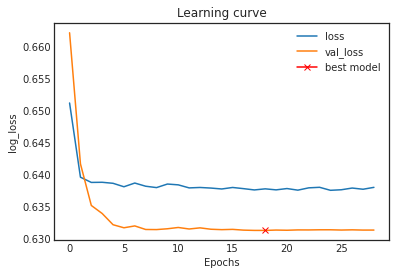

In [151]:
%matplotlib inline
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

In [152]:
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 0s 19ms/step - loss: 0.6313


0.6313208341598511